In [1]:
import syft as sy

# Part 1: Join the Duet Server the Data Owner connected to

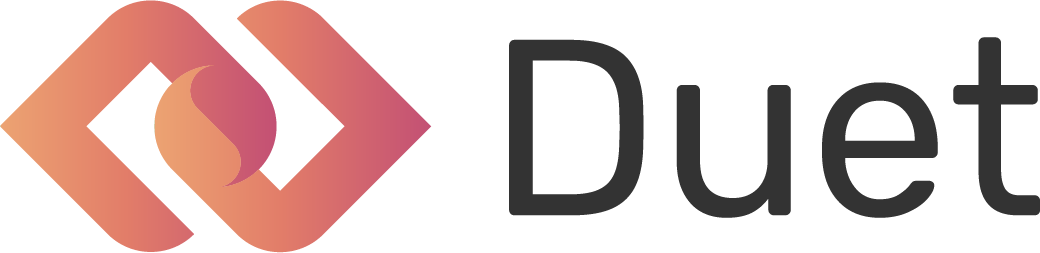

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [2]:
duet = sy.join_duet(loopback=True)

### <img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/mark-primary-light.png" alt="he-black-box" width="100"/> Checkpoint 0 : Now STOP and run the Data Owner notebook until Checkpoint 1.

# Part 2: Search for Available Data


In [3]:
# The data scientist can check the list of searchable data in Data Owner's duet store
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: 67b97239c01b47e48cfeecce5f93ff6c>,[iris-data],This is a dataset for flower classification of...,<class 'torch.Tensor'>
1,<UID: 0b4dab72f01e42e08702d1b314d7edee>,[iris-target],"Labels for flowers: Iris-setosa, Iris-versicol...",<class 'torch.Tensor'>


Data Scientist wants to use the iris dataset. (S)He needs a pointer to the data and
a pointer to the target for prediction.

In [4]:
data_ptr = duet.store[0]
target_ptr = duet.store[1]

`data_ptr` is a reference to the iris dataset remotely available on data owner's server.
`target_ptr` is a reference to the iris dataset LABELS remotely available on data owner's server

In [5]:
print(data_ptr)
print(target_ptr)

# Part 3: Perform Logistic Regression on Iris dataset
Now the data scientist can perform machine learning on the data that is in the Data Owner's duet server, without the owner having to share his/her data.

### Basic analysis

First the data scientist needs to know some basic information about the dataset.
1. The length of the dataset
2. The input dimension
3. The output dimension

These information have to be explicitly shared by the Data Owner. Let's try to find them in the data description.

In [6]:
print(duet.store.pandas["Description"][0])
print()
print(duet.store.pandas["Description"][1])

This is a dataset for flower classification of 150 samples. 4 Features are sepal length (cm),sepal width (cm), petal length (cm), petal width (cm)

Labels for flowers: Iris-setosa, Iris-versicolour, Iris-virginica


### Train model

In [7]:
import torch

In [8]:
in_dim = 4
out_dim = 3
n_samples = 150

First, let's create our model for `Logistic Regression`. If you are already familiar with PyTorch, you will notice that the model is built almost the exact same way as you do in PyTorch. The main difference is that here we inherit from `sy.Module` instead of `nn.Module`. We also need to pass in a variable called `torch_ref` which we will use internally for any calls that you would normally make to torch.

In [9]:
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.layer1 = self.torch_ref.nn.Linear(in_dim, 20)
        self.layer2 = self.torch_ref.nn.Linear(20, 30)
        self.out = self.torch_ref.nn.Linear(30, out_dim)

    def forward(self, x):
        x = self.torch_ref.nn.functional.relu(self.layer1(x))
        x = self.torch_ref.nn.functional.relu(self.layer2(x))
        output = self.torch_ref.nn.functional.log_softmax(self.out(x), dim=1)
        return output


Now we can create a local model by passing our local copy of torch.

In [10]:
local_model = SyNet(torch)

Now we will send the local copy of the model to our partner's duet server.

In [11]:
remote_model = local_model.send(duet)

Let's create an alias for our partner’s torch called `remote_torch` so we can refer to the local torch as torch and any operation we want to do remotely as `remote_torch`. Remember, the return values from `remote_torch` are Pointers, not the real objects. They mostly act the same when using them with other Pointers but they cannot be mixed with local torch objects.

In [12]:
remote_torch = duet.torch

We will get a pointer to our remote model parameters. Then we will set our optimizer. Here, we will be using `Adam optimizer`. `params` is a pointer to the list of parameters. `optim` is a reference to the Adam optimizer which can be used to optimize the remote model.

In [13]:
params = remote_model.parameters()
optim = remote_torch.optim.Adam(params=params, lr=0.01)
print("params:", params)
print("optim:", optim)

params: <syft.proxy.syft.lib.python.ListPointer object at 0x7ff6f337db50>
optim: <syft.proxy.torch.optim.AdamPointer object at 0x7ff6f3752fa0>


Now we will create our `train` function. It will take few parameters, like the `remote_model`, `torch_ref`, `optim` and `data_ptr` and `target_ptr`.

In [14]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):

    losses = []

    for i in range(iterations):

        optim.zero_grad()

        output = model(data_ptr)

        # nll_loss = negative log-liklihood loss
        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long())

        loss_item = loss.item()

        loss_value = loss_item.get(
            reason="To evaluate training progress", request_block=True, timeout_secs=5
        )

        if i % 10 == 0:
            print("Epoch", i, "loss", loss_value)

        losses.append(loss_value)

        loss.backward()

        optim.step()

    return losses

In [15]:
iteration = 50
losses = train(iteration, remote_model, remote_torch, optim, data_ptr, target_ptr)

Epoch 0 loss 1.0796849727630615
Epoch 10 loss 0.5714002251625061
Epoch 20 loss 0.3424682021141052
Epoch 30 loss 0.1636747419834137
Epoch 40 loss 0.08646260201931


In [16]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'iteration')

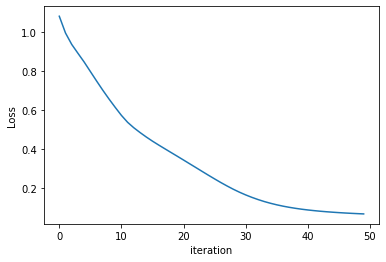

In [17]:
plt.plot(range(iteration), losses)
plt.ylabel("Loss")
plt.xlabel("iteration")

### Download model

In [18]:
def get_local_model(model):
    if not model.is_local:
        local_model = model.get(
            request_block=True,
            reason="To run test and inference locally",
            timeout_secs=5,
        )
    else:
        local_model = model

    return local_model


local_model = get_local_model(remote_model)

### Test on local data

In [19]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [20]:
iris_test = pd.read_csv("./data/iris-test.csv")
iris_test.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.8,4.0,1.2,0.2,0
1,5.7,4.4,1.5,0.4,0
2,6.0,2.7,5.1,1.6,1
3,6.0,2.9,4.5,1.5,1
4,5.8,2.7,5.1,1.9,2


In [21]:
X_test = iris_test.loc[:, iris_test.columns != "species"]
y_test = iris_test["species"]

In [22]:
X_test = torch.FloatTensor(np.array(X_test))
y_test = torch.LongTensor(np.array(y_test))

In [ ]:
preds = []
with torch.no_grad():
    for i in range(len(X_test)):
        sample = X_test[i]
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()
        print(f"Prediction: {pred} Ground Truth: {y_test[i]}")
        preds.append(pred)

In [ ]:
acc = accuracy_score(y_test, preds)
print("Overall test accuracy", acc * 100)